In [1]:
import numpy as np
import h5py
%matplotlib inline
from IPython.display import Image

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'large',
         'ytick.labelsize': 'large'}
pylab.rcParams.update(params)

from astropy.io import fits
from astropy.visualization import make_lupton_rgb

In [6]:
#tag = 'gri_cosmos'
tag = 'gri'
base_dir = '/scratch/ksf293/kavli/anomaly'
imarr_fn = f'{base_dir}/data/images_h5/images_{tag}.h5'
results_fn = f'{base_dir}/results/results_{tag}.h5'
imdict_fn = f'{base_dir}/data/idxdicts_h5/idx2imloc_{tag}.npy'
resdict_fn = f'{base_dir}/data/idxdicts_h5/idx2resloc_{tag}.npy'

In [4]:
plot_dir = '../papers/paper_neurips/images'

In [7]:
imarr = h5py.File(imarr_fn, 'r')
res = h5py.File(results_fn, 'r')
print(imarr.keys())
print(res.keys())
print(len(imarr['idxs']))

<KeysViewHDF5 ['idxs', 'images', 'object_ids']>
<KeysViewHDF5 ['anomaly_scores', 'anomaly_scores_norm', 'anomaly_scores_rank', 'disc_scores', 'disc_scores_norm', 'disc_scores_rank', 'gen_scores', 'gen_scores_norm', 'gen_scores_rank', 'idxs', 'object_ids', 'reconstructed']>
942782


In [13]:
idx2imloc = np.load(imdict_fn, allow_pickle=True).item()
idx2resloc = np.load(resdict_fn, allow_pickle=True).item()

In [6]:
# idx2imloc = {}
# for i in range(len(imarr['idxs'])):
#     if i%100000==0: 
#         print(i)
#     idx2imloc[imarr['idxs'][i]] = i

In [7]:
# idx2resloc = {}
# for i in range(len(res['idxs'])):
#     if i%100000==0: 
#         print(i)
#     idx2resloc[res['idxs'][i]] = i

In [14]:
def luptonize(x, rgb_q=15, rgb_stretch=0.5, rgb_min=0):
    if x.ndim==3:
        x = make_lupton_rgb(x[:,:,2], x[:,:,1], x[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
    elif x.ndim==4:
        x = np.array([make_lupton_rgb(xi[:,:,2], xi[:,:,1], xi[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
                      for xi in x])
    else:
        raise ValueError(f"Wrong number of dimensions! Gave {x.ndim}, need 3 or 4")
    return x

In [15]:
def plot_ims(ids, nrows, ncols, saveto=None):
    assert len(ids)<=nrows*ncols, "bad rows/cols for number of ids!"
    
    subsize = 2
    fig, axarr = plt.subplots(nrows,ncols,figsize=(ncols*subsize,nrows*subsize))
    plt.subplots_adjust(hspace=0.2, wspace=0.05)

    count = 0
    for i in range(nrows):
        for j in range(ncols):
            idx = ids[count]
            loc = idx2imloc[idx]
            im = imarr['images'][loc]
            obj_id = int(imarr['object_ids'][loc])
            if nrows==1 and ncols==1:
                ax = axarr
            elif nrows==1:
                ax = axarr[j]
            elif ncols==1:
                ax = axarr[i]
            else:
                ax = axarr[i][j]
            title = f"ID: {obj_id}"
            ax.set_title(title, fontsize=8)
            ax.imshow(luptonize(im))
            ax.set_xticks([])
            ax.set_yticks([])
            count += 1
            
            if count>=len(ids):
                break
                
    if saveto:
        plt.savefig(saveto, bbox_inches='tight')#, pad_inches=0)

In [16]:
bluecore_ids = [935055, 936569, 941128, 782291]
sf_ids = [461525, 702705, 402208, 549909]
tidal_ids = [406992,105162,232476,402855] #936581

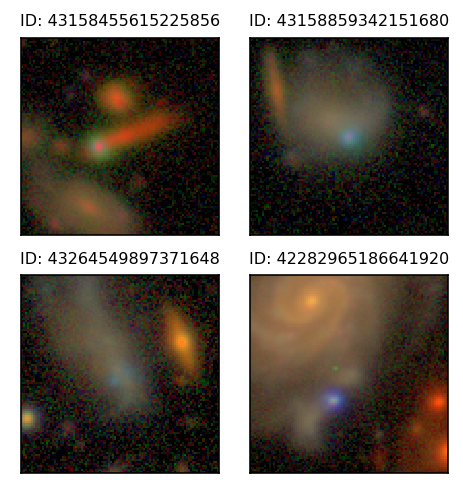

In [74]:
plot_ims(bluecore_ids, 2, 2, saveto=f'{plot_dir}/anomalies_bluecore.png')

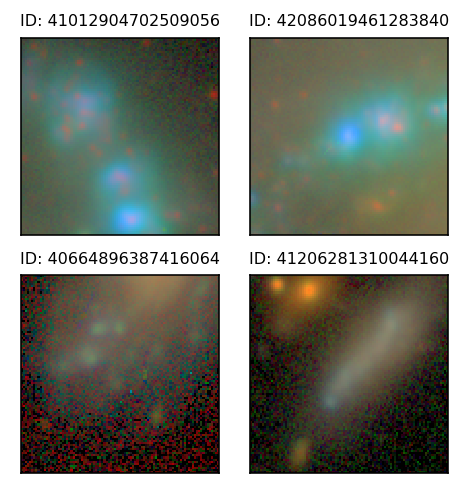

In [75]:
plot_ims(sf_ids, 2, 2, saveto=f'{plot_dir}/anomalies_starforming.png')

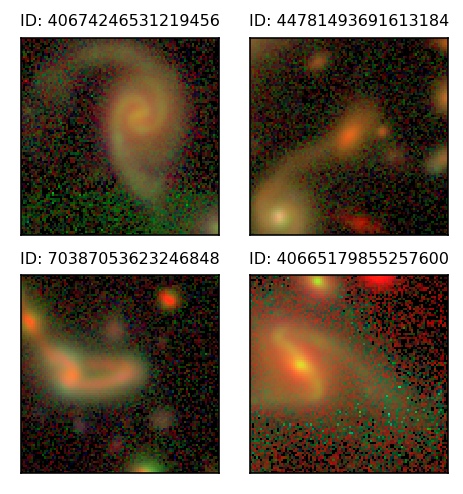

In [76]:
plot_ims(tidal_ids, 2, 2, saveto=f'{plot_dir}/anomalies_tidalfeatures.png')

In [8]:
def get_residual(im, recon):
    im = np.array(im)
    reals = im.reshape((96,96,-1))
    #reals = luptonize(reals).astype('int')
    recon = np.array(recon)
    recon = recon.reshape((96,96,-1)).astype('int')
    resid = abs(im-recon)
    return resid

In [9]:
def plot_recons(ids, saveto=None):
    nims = len(ids)
    subsize = 2
    fig, axarr = plt.subplots(3,nims,figsize=(nims*subsize,3*subsize))
    plt.subplots_adjust(hspace=0.02, wspace=0.1)
    count = 0
    for i in range(nims):
        idx = ids[i]
        
        loc = idx2imloc[idx]
        im = luptonize(imarr['images'][loc])
        obj_id = int(imarr['object_ids'][loc])
        
        rloc = idx2resloc[idx]
        recon = res['reconstructed'][rloc]
        score = float(res['anomaly_scores'][rloc])
        resid = get_residual(im, recon)
        
        ax0 = axarr[0][i]
        ax1 = axarr[1][i]
        ax2 = axarr[2][i]
        title = r'''ID: {}
$s_\mathrm{{anom}}$ = {:.2f}'''.format(obj_id, score)
        ax0.set_title(title, fontsize=8)
        ax0.imshow(im)
        ax1.imshow(recon)
        ax2.imshow(resid)
        
        if i==0:
            fsize=13
            ax0.set_ylabel("real",fontsize=fsize)
            ax1.set_ylabel("reconstructed",fontsize=fsize)
            ax2.set_ylabel("residual",fontsize=fsize)
        
        for ax in [ax0, ax1, ax2]:
            ax.set_xticks([])
            ax.set_yticks([])
          
    if saveto:
        plt.savefig(saveto, bbox_inches='tight')#, pad_inches=0)

In [10]:
def plot_dist(scores_all, bins=150, save_fn=None, labels=None):
    plt.figure(figsize=(7,5))
    scores_all = np.array(scores_all)
    print(scores_all.shape)
    if not isinstance(scores_all[0], list) or isinstance(scores_all[0], np.ndarray):
        print("Single array, adding outer list")
        scores_all = [scores_all]
        colors = ['blue']
        lcolors = ['black']
    else:
        color_idx = np.linspace(0, 1, len(scores_all))
        colors = [plt.cm.rainbow(color_idx[i]) for i in range(len(scores_all))]
        lcolors = colors
    for i in range(len(scores_all)):
        scores = scores_all[i]
        color = colors[i]
        lcolor = lcolors[i]
        print(len(scores))
        mean = np.mean(scores)
        std = np.std(scores)
        print(len([s for s in scores if s>mean+3*std]))
        #color = plt.cm.rainbow(color_idx[i])
        if labels is not None:
            plt.hist(scores, bins=bins, histtype='step', color=color, lw=2, label=labels[i])
            plt.legend()
        else:
            plt.hist(scores, bins=bins, histtype='step', color=color, lw=2)
        plt.axvline(mean, lw=1, color=lcolor)
        plt.axvline(mean+std, lw=0.8, color=lcolor, ls='--')
        plt.axvline(mean-std, lw=0.8, color=lcolor, ls='--')
        plt.axvline(mean+2*std, lw=0.6, color=lcolor, ls='--')
        plt.axvline(mean-2*std, lw=0.6, color=lcolor, ls='--')
        plt.axvline(mean+3*std, lw=0.4, color=lcolor, ls='--')
        plt.axvline(mean-3*std, lw=0.4, color=lcolor, ls='--')
    plt.xlabel('anomaly score')
    plt.ylabel('#')
    plt.xlim(0,4000)
    if save_fn:
        plt.savefig(save_fn, bbox_inches='tight')#, pad_inches=0)

In [14]:
scores = res['anomaly_scores']
ridxs = res['idxs']

(942781,)
Single array, adding outer list
942781
9648


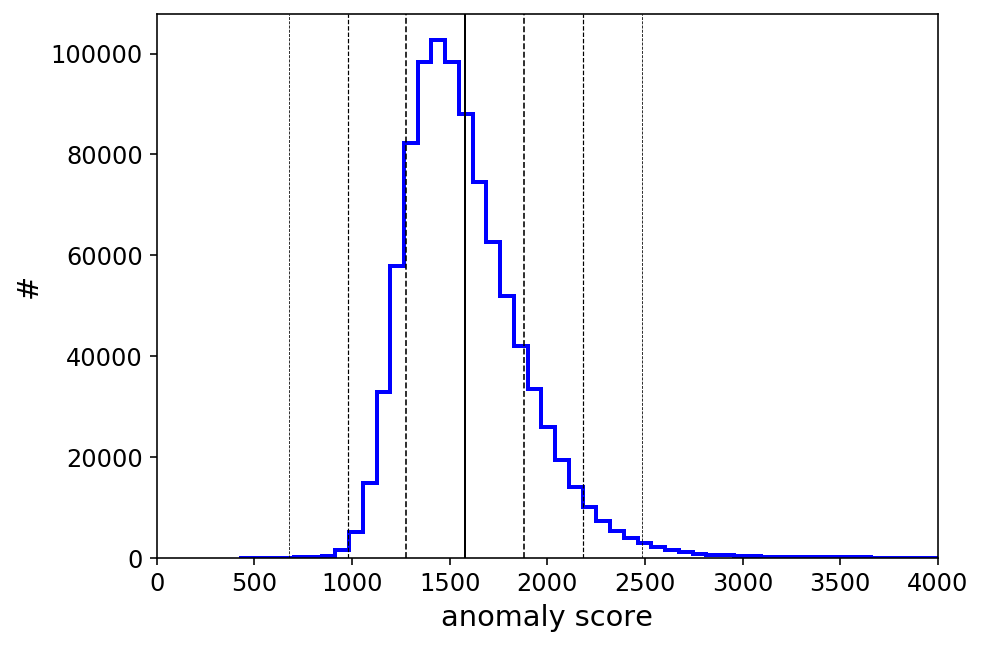

In [18]:
plot_dist(scores)

In [15]:
def get_anomalies(scores, idxs, sigma_min, sigma_max, n=4, seed=17):
    np.random.seed(seed)
    scores = np.array(scores)
    mean = np.mean(scores)
    std = np.std(scores)
    amin = mean+sigma_min*std
    amax = mean+sigma_max*std
    aindices = np.where((scores >= amin) & (scores < amax))[0]
    aindices_n = np.random.choice(aindices, n)
    return np.array(idxs)[aindices_n]

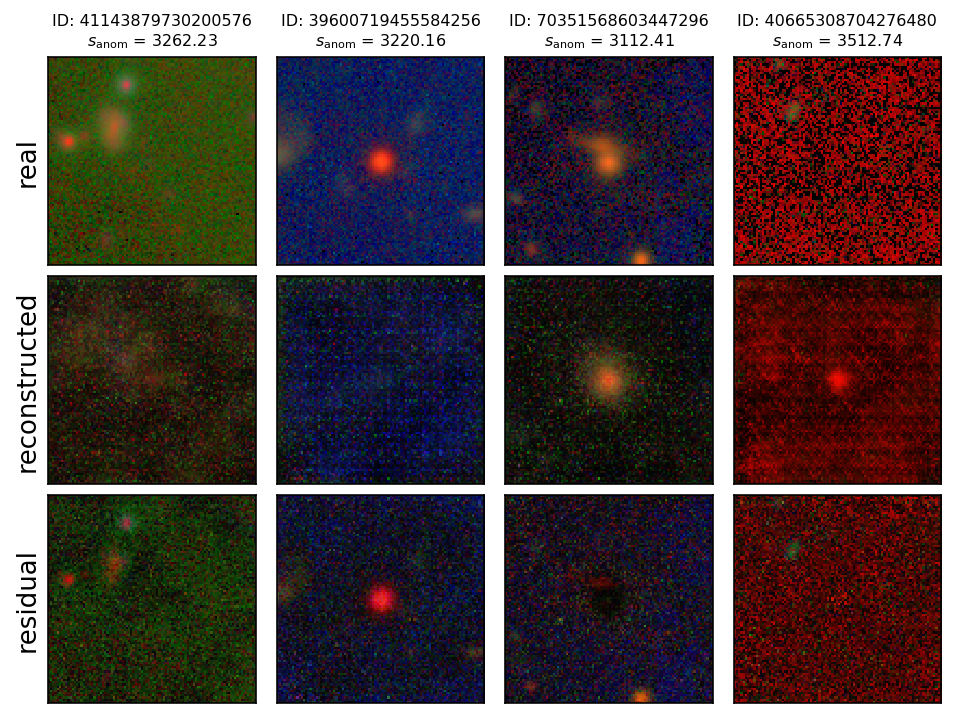

In [60]:
ids_59sig = get_anomalies(scores, ridxs, 5, 9)
plot_recons(ids_59sig, saveto=f'{plot_dir}/recons_59sig.png')

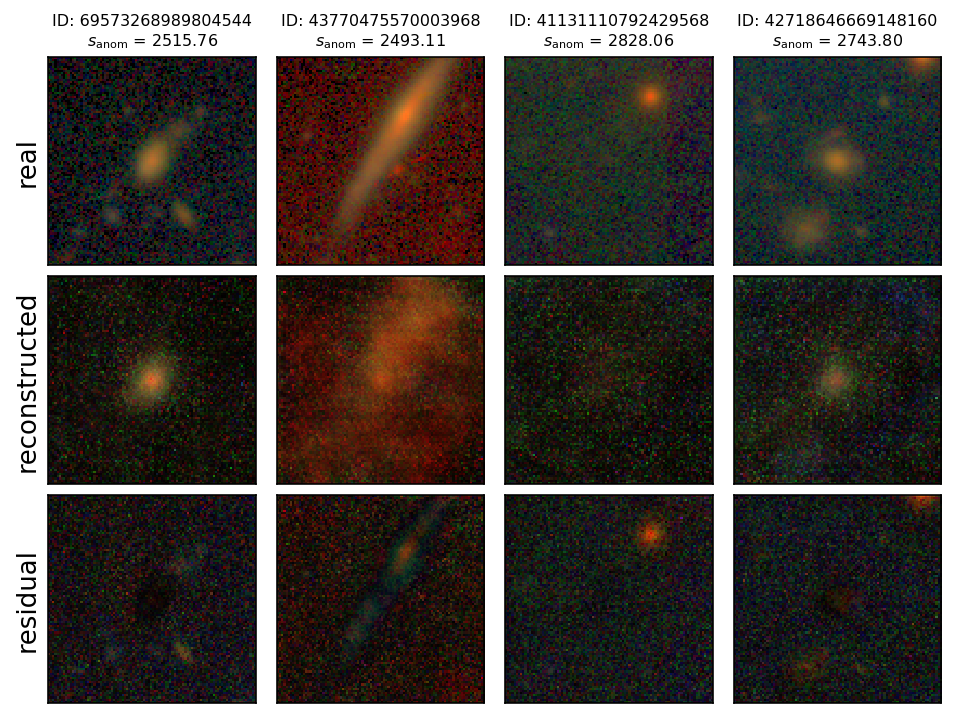

In [80]:
ids_35sig = get_anomalies(scores, ridxs, 3, 5)
plot_recons(ids_35sig, saveto=f'{plot_dir}/recons_35sig.png')

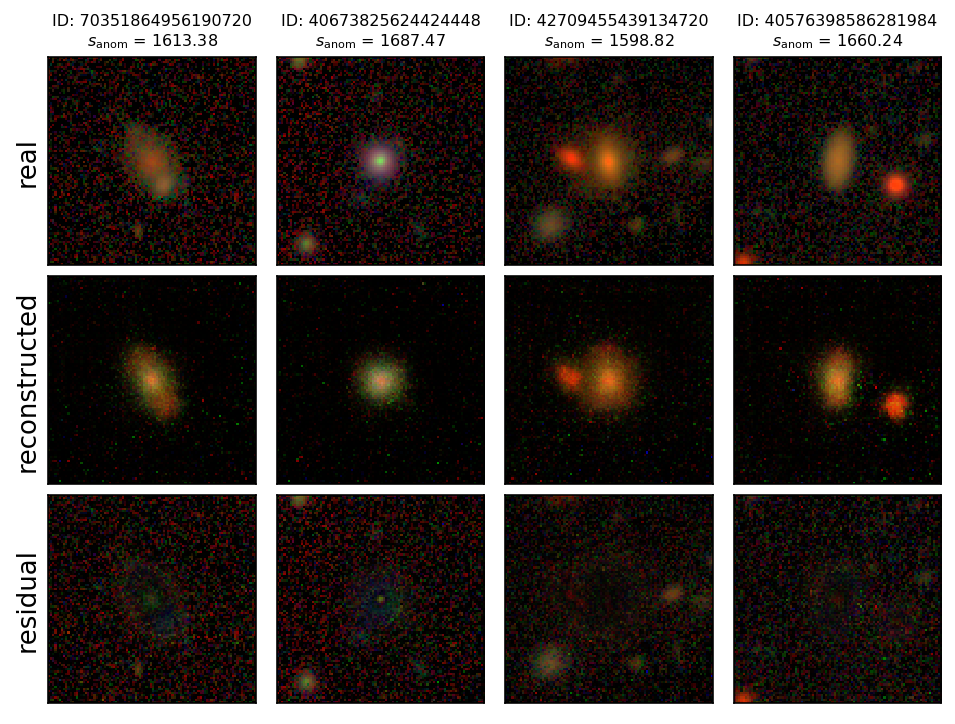

In [81]:
ids_01sig = get_anomalies(scores, ridxs, 0, 1)
plot_recons(ids_01sig, saveto=f'{plot_dir}/recons_01sig.png')

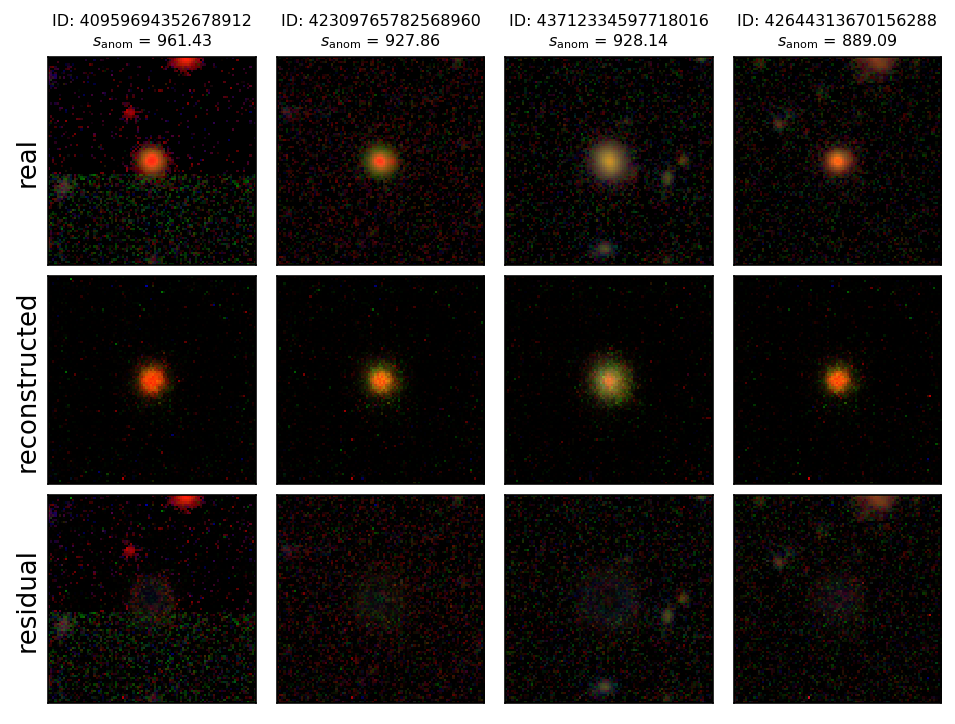

In [82]:
ids_n3n2sig = get_anomalies(scores, ridxs, -3, -2)
plot_recons(ids_n3n2sig, saveto=f'{plot_dir}/recons_n3n2sig.png')

## Figure 1 w reconstructions, but fewer and smaller

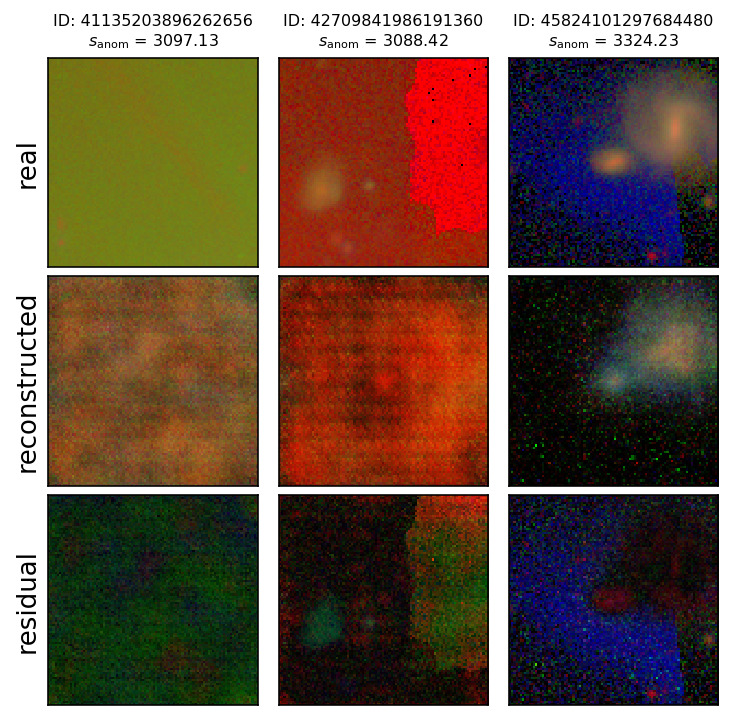

In [58]:
ids_59sig = get_anomalies(scores, ridxs, 5, 9, n=3, seed=23) #15,19 good
plot_recons(ids_59sig, saveto=f'{plot_dir}/recons_59sig_3.png')

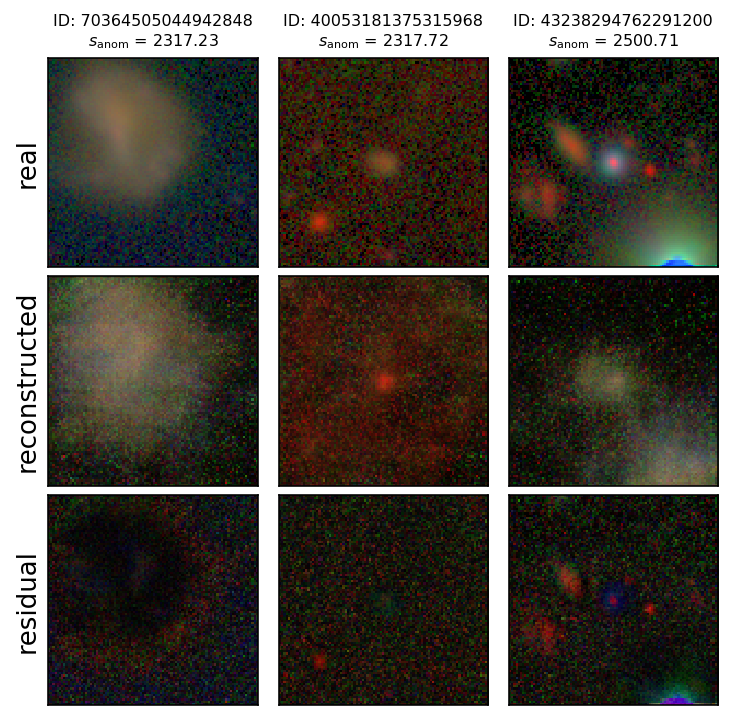

In [57]:
ids_59sig = get_anomalies(scores, ridxs, 2, 4, n=3, seed=19) #14, 11,3 best so far = #8 has a nice gal!!
plot_recons(ids_59sig, saveto=f'{plot_dir}/recons_24sig_3.png')

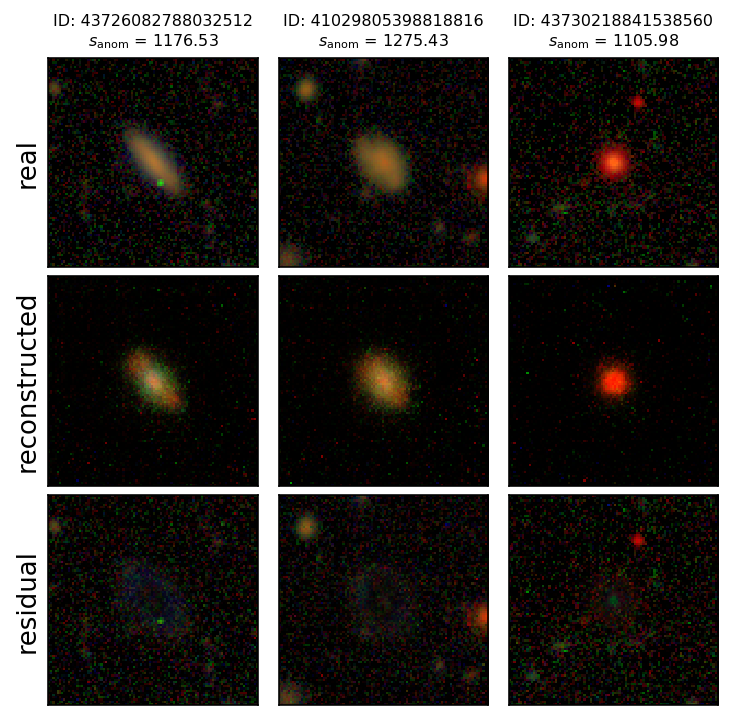

In [59]:
ids_59sig = get_anomalies(scores, ridxs, -3, -1, n=3, seed=15)
plot_recons(ids_59sig, saveto=f'{plot_dir}/recons_n3n1sig_3.png')

## Spectrum

In [3]:
hdul = fits.open('../data/keck_data/bluedot/bluedot_coadd.fits')

In [4]:
info = hdul.info()
hdr = hdul[0].header
data = hdul[1].data

Filename: ../data/keck_data/bluedot/bluedot_coadd.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (2223,)   uint8   
  1  /Users/yifei/Dropbox/Keck_Data/data4kate_reduced/bluedot/keck_dei...    1 BinTableHDU     20   8109R x 4C   [D, D, D, K]   


In [5]:
w = data['wave']
f = data['flux']

In [23]:
def plot_spectrum(w, f, saveto=None):
    plt.figure(figsize=(12,4))
    plt.plot(w, f, color='k')
    plt.xlabel(r'wavelength ($\AA$)')
    plt.ylabel('flux')
    plt.xlim(4700, 8000)
    plt.ylim(-300, 2200)
    if saveto:
        plt.savefig(saveto, bbox_inches='tight')#, pad_inches=0)

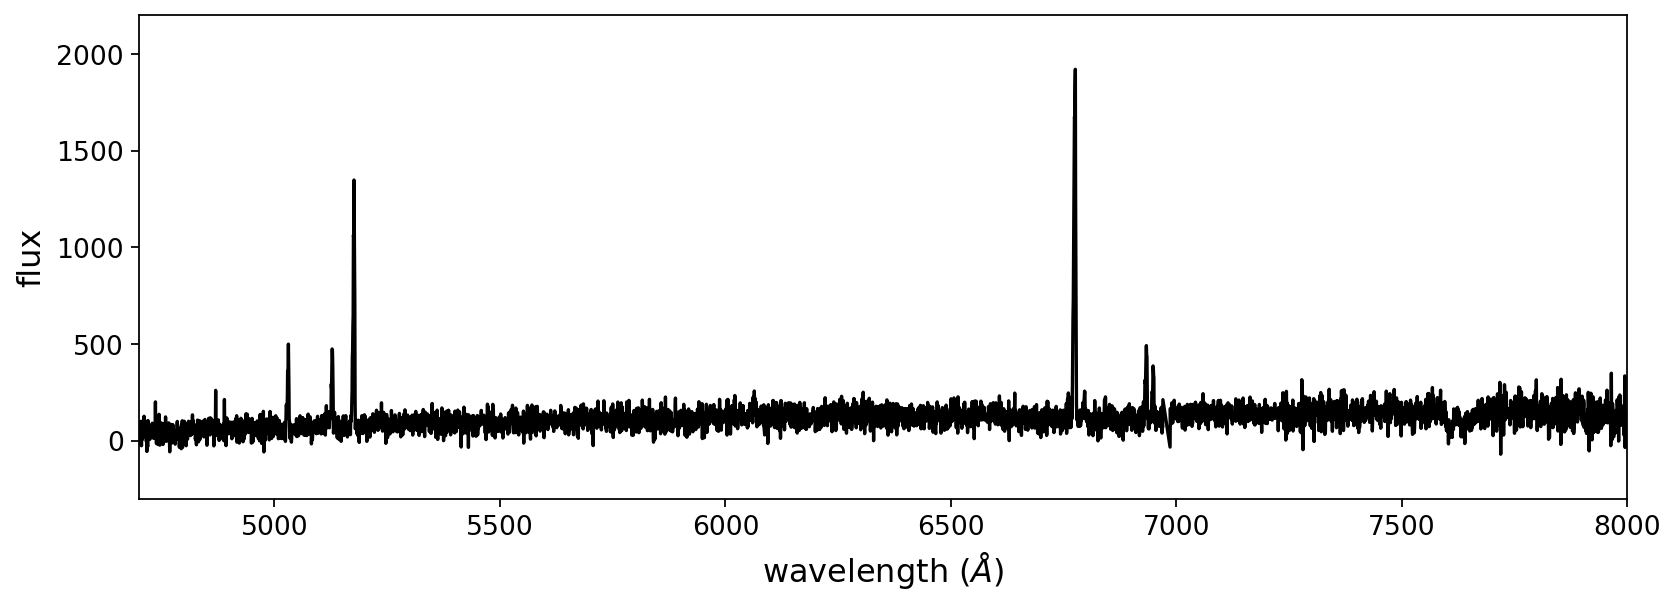

In [24]:
plot_spectrum(w,f,saveto=f'{plot_dir}/bluedot_spectrum.png')

## Autoencodes

In [54]:
def plot_umap(embedding, saveto=None, highlight_arrs=None, highlight_colors=None, 
              highlight_markers=None, cmap='plasma_r'):
    e1, e2, colorby, idxs = embedding
    plt.figure(figsize=(8,7))
    plt.scatter(e1, e2, marker='.', c=colorby, cmap=cmap, s=40, vmin=min(colorby), vmax=4000)
    if highlight_arrs is not None:
        if np.array(highlight_arrs).ndim==1:
            highlight_arrs = [highlight_arrs]
        for i, highlight_ids in enumerate(highlight_arrs):
            argidxs = [np.where(idxs==hi)[0][0] for hi in highlight_ids]
            plt.scatter(e1[argidxs], e2[argidxs], marker=highlight_markers[i], c=colorby[argidxs], 
                            edgecolor=highlight_colors[i], lw=2, 
                            cmap=cmap, s=270, vmin=min(colorby), vmax=4000)
    plt.xlabel('umap A')
    plt.ylabel('umap B')

    cbar = plt.colorbar(extend='max')
    cbar.set_label(r'$s_\mathrm{anom}$, anomaly score', rotation=270, labelpad=18)
    plt.gca().set_aspect('equal', 'datalim')
    if saveto:
        plt.savefig(saveto, bbox='tight')

### 3sig

In [19]:
embed_dir = "/scratch/ksf293/kavli/anomaly/results/embeddings"
taga = 'gri_3sig'
umap_tag = '_nn5md0.1'
auto_tag = '_model29500_latent32'

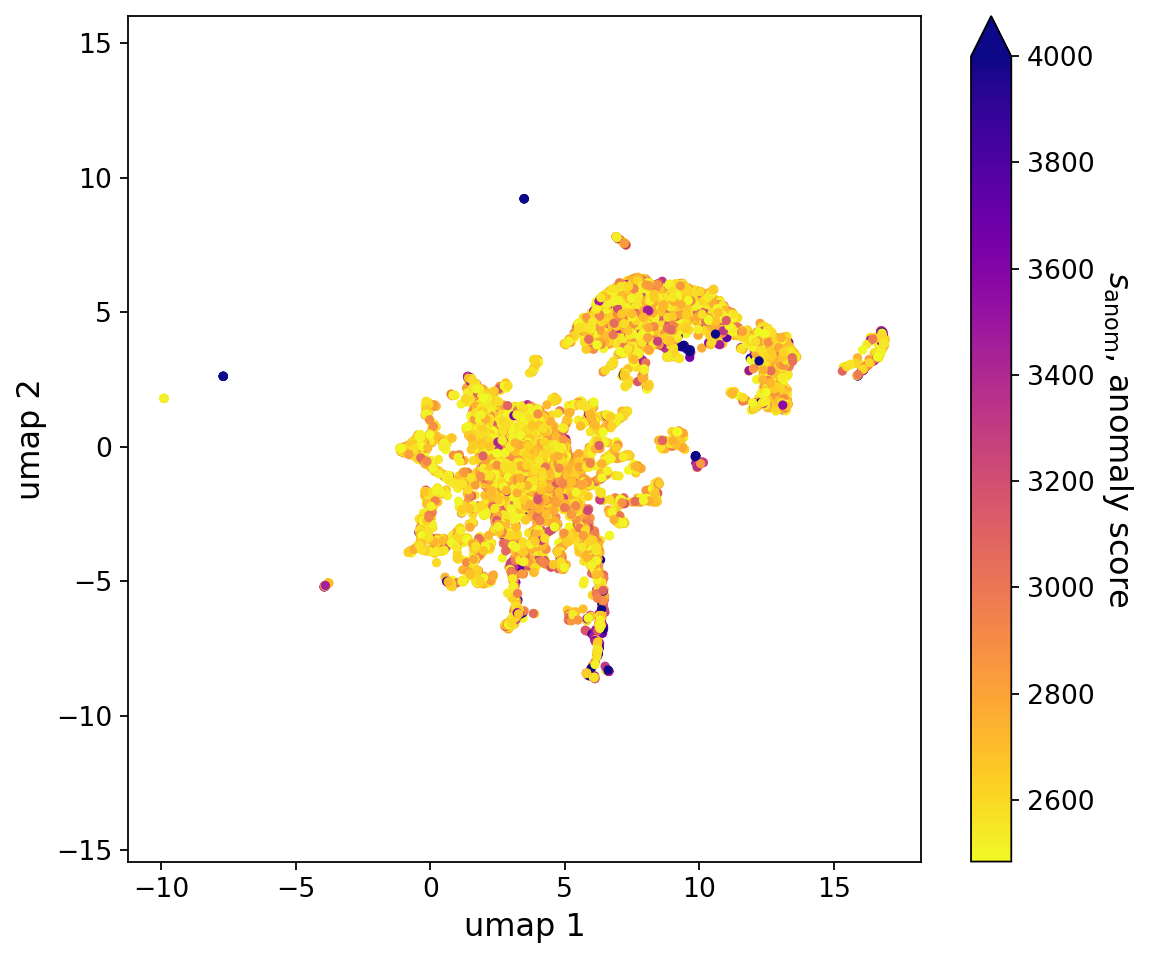

In [80]:
embedding = np.load(f"{embed_dir}/embedding_umap_reals_{taga}{umap_tag}.npy")
plot_umap(embedding, saveto=f'{plot_dir}/umap_3sig_reals.png')

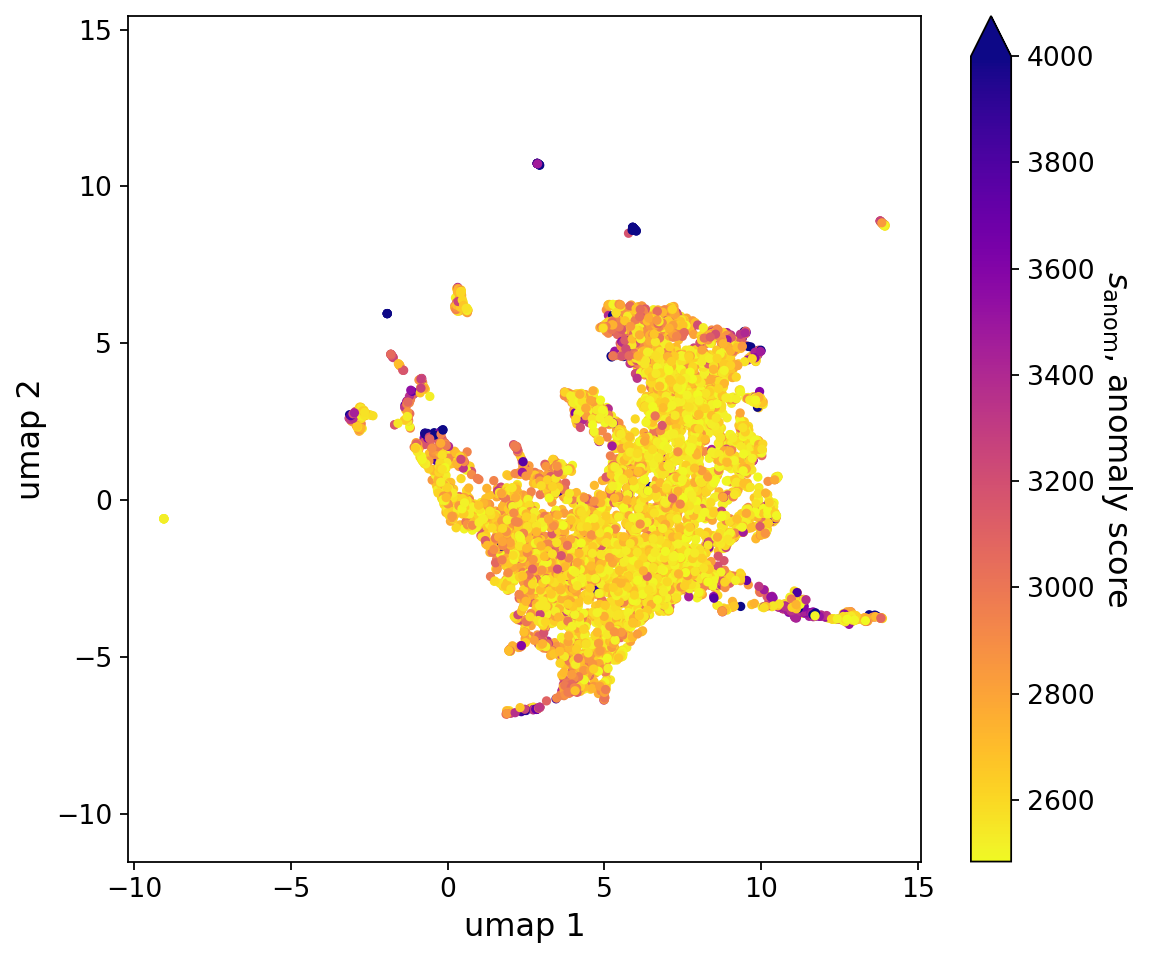

In [81]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}_real{umap_tag}.npy", allow_pickle=True)
plot_umap(embedding, saveto=f'{plot_dir}/umap_3sig_reals_auto.png')

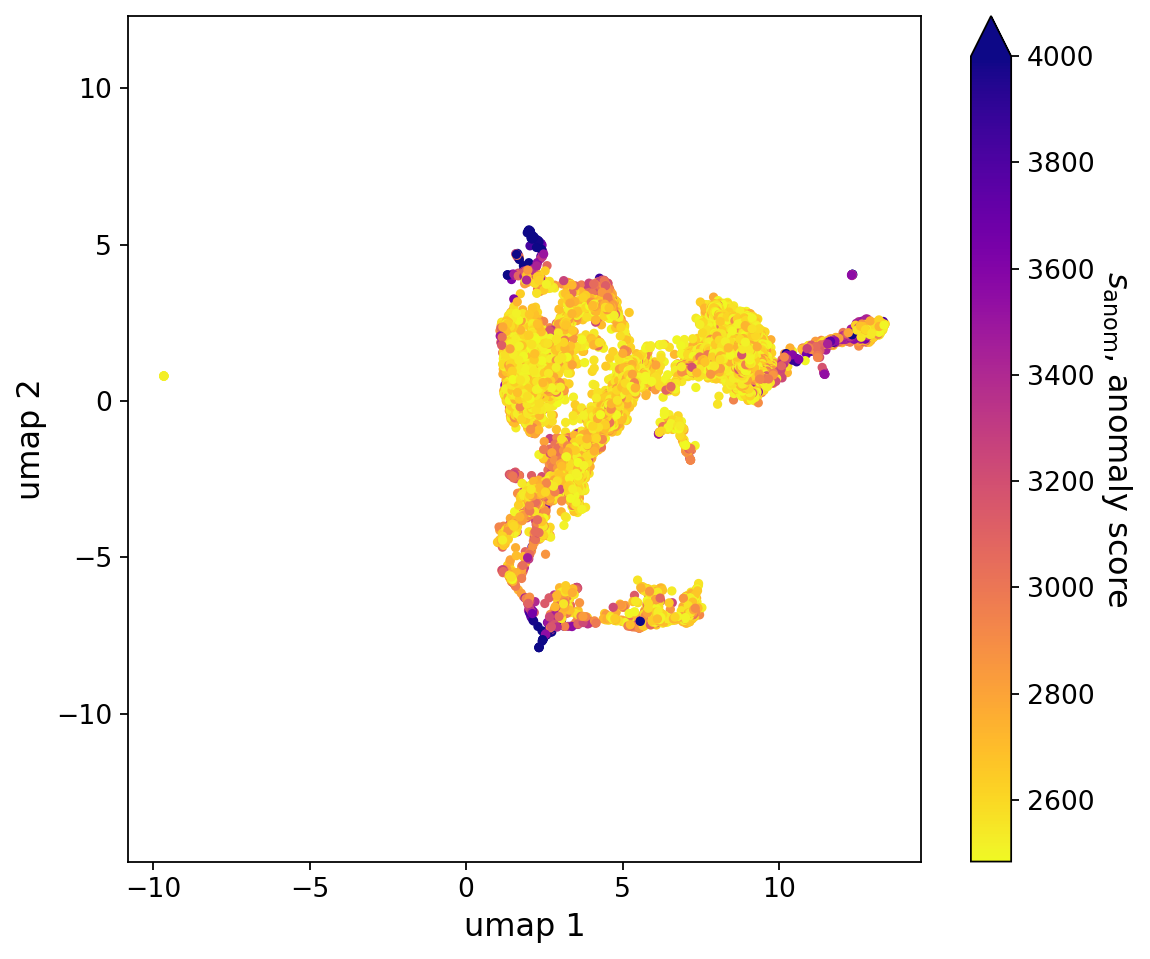

In [82]:
embedding = np.load(f"{embed_dir}/embedding_umap_residuals_{taga}{umap_tag}.npy")
plot_umap(embedding, saveto=f'{plot_dir}/umap_3sig_resids.png')

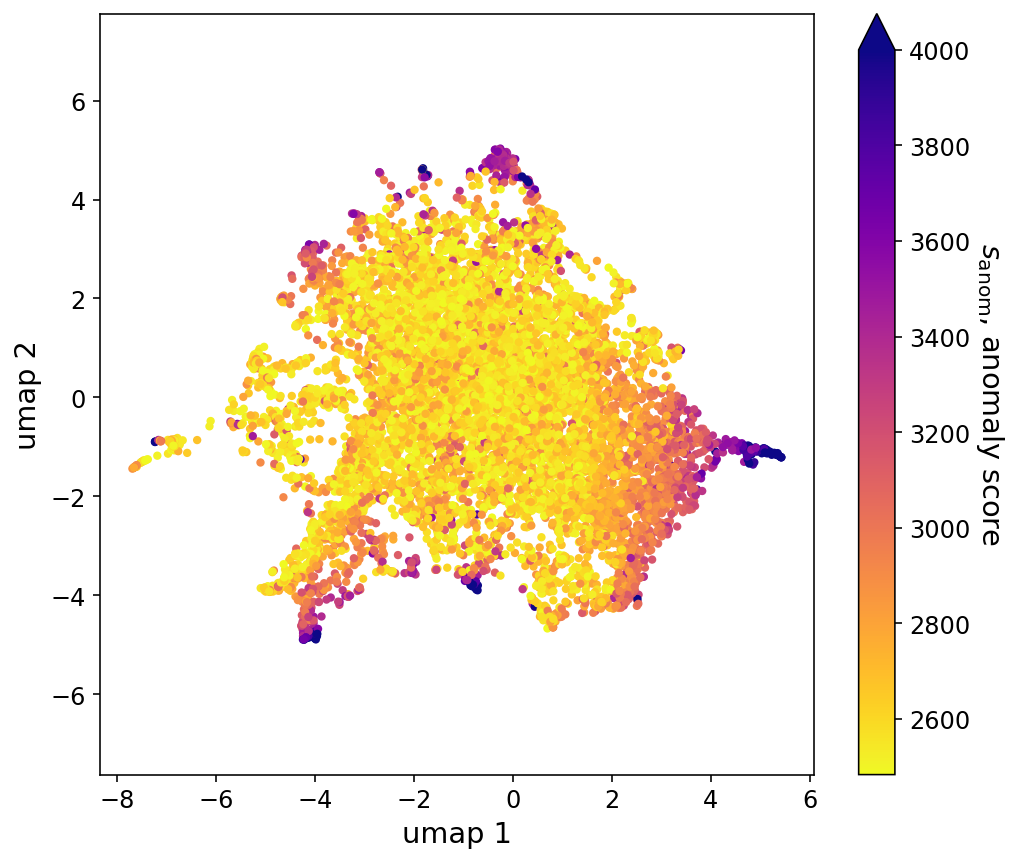

In [103]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}{umap_tag}.npy", allow_pickle=True)
plot_umap(embedding, saveto=f'{plot_dir}/umap_3sig_resids_auto.png')

### 100k

In [99]:
embed_dir = "/scratch/ksf293/kavli/anomaly/results/embeddings"
taga = 'gri_100k'
umap_tag = '_nn5md0.1'
auto_tag = '_model29500_latent16'

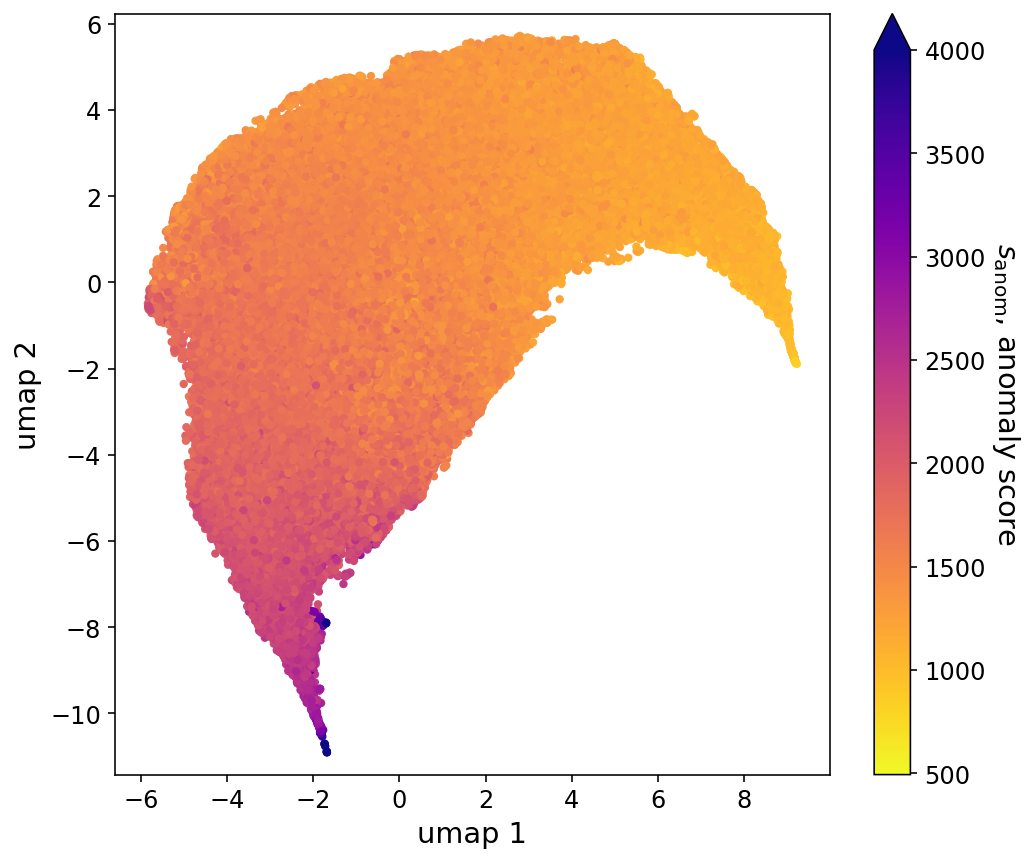

In [100]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}{umap_tag}.npy", allow_pickle=True)
plot_umap(embedding, saveto=f'{plot_dir}/umap_100k_resids_auto.png')

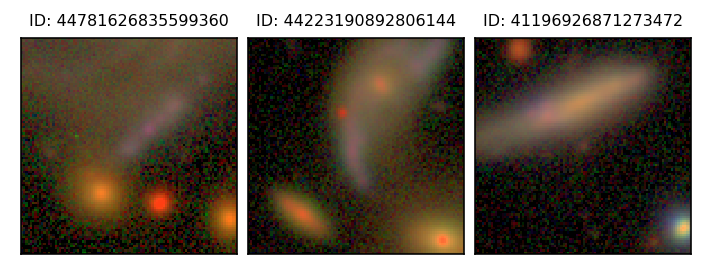

In [23]:
extended_purple = [105685, 80217, 539520]#, 378977, 43986, 355424]
saveto = f'{plot_dir}/cluster_extendedpurple.png'
plot_ims(extended_purple,1,3,saveto=saveto)#, saveto=f'{plot_dir}/anomalies_tidal_purple.png')

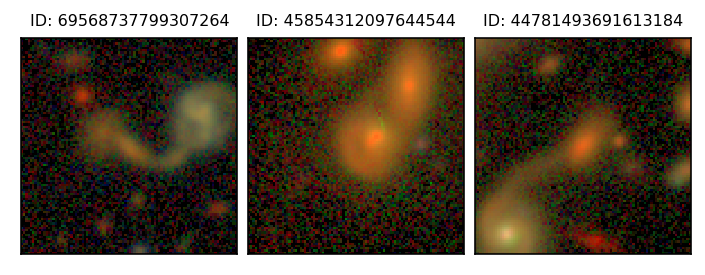

In [24]:
mergers_upper = [157767,147100,105162]
saveto = f'{plot_dir}/cluster_mergers.png'
plot_ims(mergers_upper,1,3,saveto=saveto)

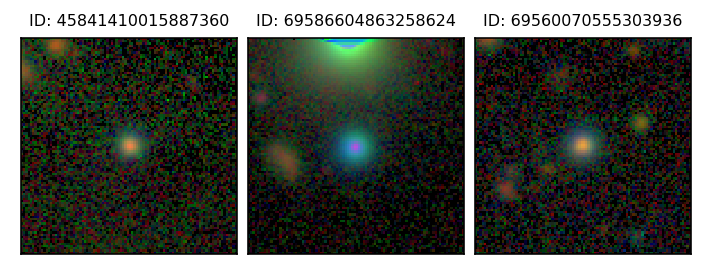

In [25]:
blue_dots_isolated = [137543,168508,153414]#,267827]
plot_ims(blue_dots_isolated,1,3)

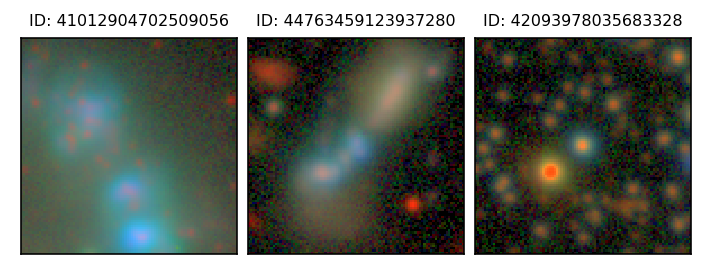

In [26]:
blue_sf = [461525, 86279,707620]#,782291]
saveto = f'{plot_dir}/cluster_bluesf.png'
plot_ims(blue_sf,1,3,saveto=saveto)

In [27]:
embed_dir = "/scratch/ksf293/kavli/anomaly/results/embeddings"
taga = 'gri_3sig'
umap_tag = '_nn5md0.1'
auto_tag = '_model29500_latent32'

In [21]:
def get_highlights(highlight_arrs, colors, markers):
    assert len(highlight_arrs)==len(colors) and len(colors)==len(markers), "arrays must be same length!"
    highlight_ids = np.concatenate(highlight_arrs)
    highlight_colors = [[colors[c]]*len(highlight_arrs[c]) for c in range(len(colors))]
    highlight_colors = np.concatenate(highlight_colors)
    highlight_markers = [[markers[m]]*len(highlight_arrs[m]) for m in range(len(markers))]
    highlight_markers = np.concatenate(highlight_markers)
    return highlight_ids, highlight_colors, highlight_markers

[2054, 1571, 752, 754, 650, 7208, 6302, 666, 8205]


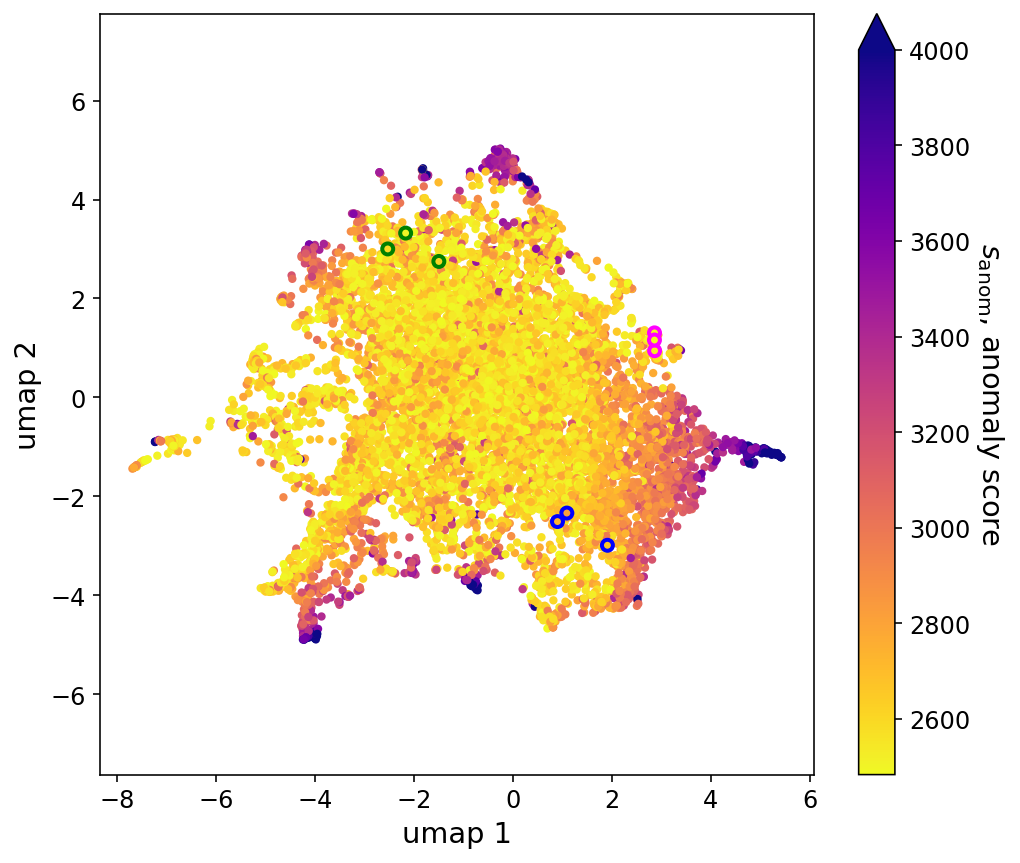

In [93]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}{umap_tag}.npy", allow_pickle=True)
highlight_ids, highlight_colors = get_highlights(
                [mergers_upper, extended_purple, blue_sf],
                ['green', 'magenta', 'blue'])
saveto = f'{plot_dir}/umap_3sig_resids_auto_highlight.png'
plot_umap(embedding, highlight_ids=highlight_ids, highlight_colors=highlight_colors, saveto=saveto)

# Use stars on UMAP!

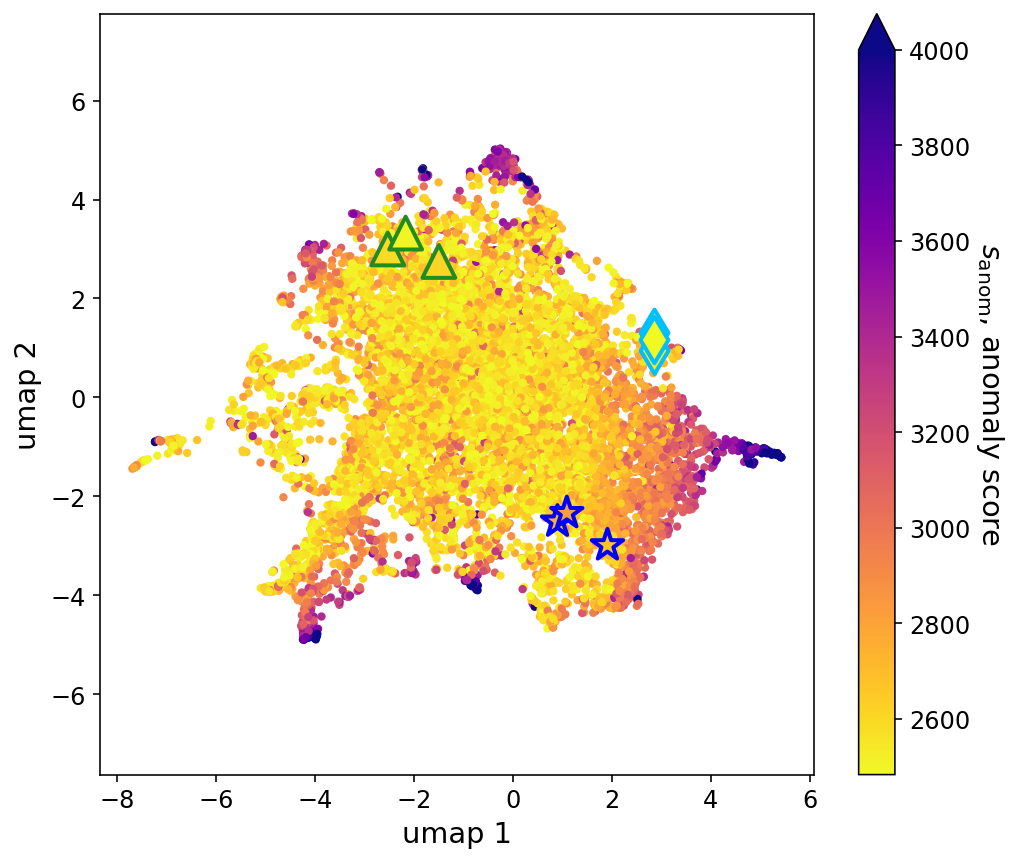

In [45]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}{umap_tag}.npy", allow_pickle=True)
highlight_ids, highlight_colors, highlight_markers = get_highlights(
                [mergers_upper, extended_purple, blue_sf],
                ['forestgreen', 'deepskyblue', 'blue'],
                ['*', '*', '*'])
highlight_arrs = [mergers_upper, extended_purple, blue_sf]
highlight_colors = ['forestgreen', 'deepskyblue', 'blue']
highlight_markers = ['^', 'd', '*']
saveto = f'{plot_dir}/umap_3sig_resids_auto_highlight.png'
plot_umap(embedding, highlight_arrs=highlight_arrs, highlight_colors=highlight_colors, 
          highlight_markers=highlight_markers, saveto=saveto)

In [52]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Purples')
cmap_purp = truncate_colormap(cmap, 0.25, 1.0)

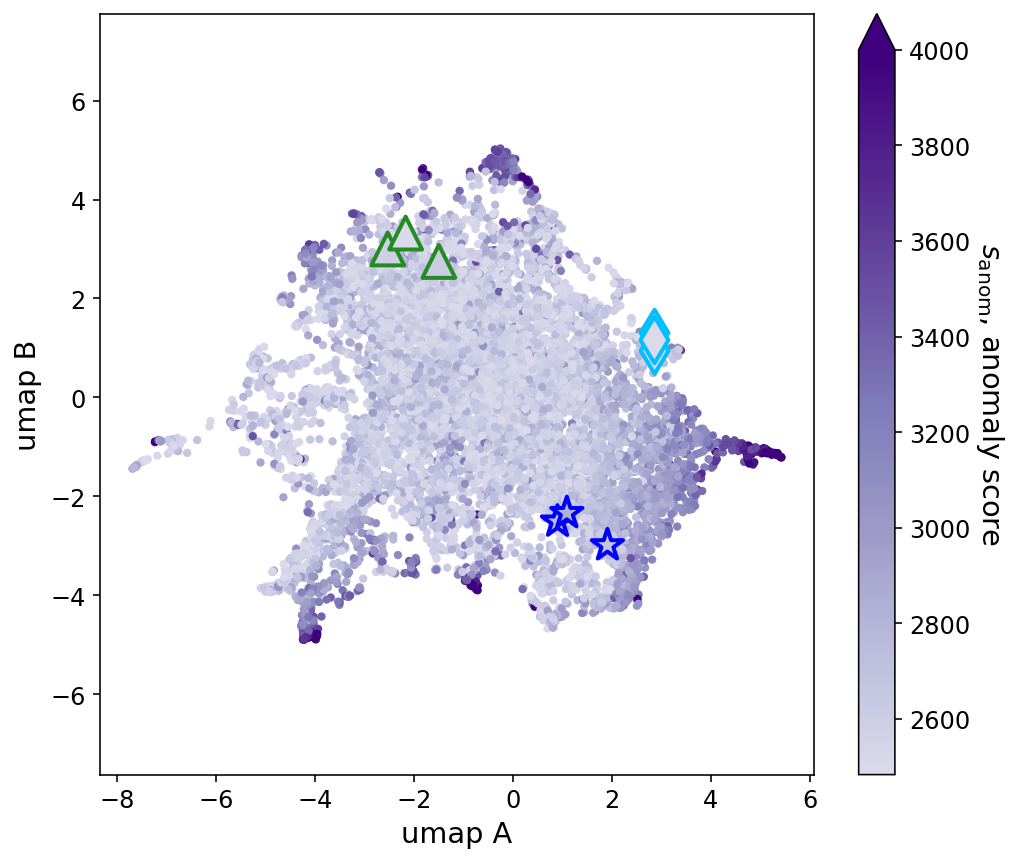

In [55]:
embedding = np.load(f"{embed_dir}/embedding_umap_auto_{taga}{auto_tag}{umap_tag}.npy", allow_pickle=True)
highlight_arrs = [mergers_upper, extended_purple, blue_sf]
highlight_colors = ['forestgreen', 'deepskyblue', 'blue']
highlight_markers = ['^', 'd', '*']
saveto = f'{plot_dir}/umap_3sig_resids_auto_highlight.png'
plot_umap(embedding, highlight_arrs=highlight_arrs, highlight_colors=highlight_colors, 
          highlight_markers=highlight_markers, saveto=saveto, cmap=cmap_purp)

## include residual images in fig 2

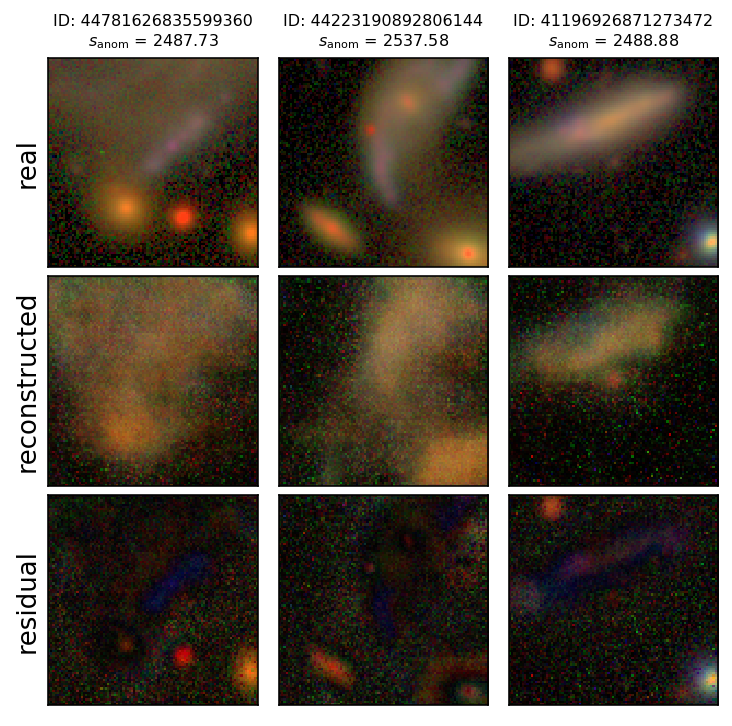

In [17]:
extended_purple = [105685, 80217, 539520]#, 378977, 43986, 355424]
saveto = f'{plot_dir}/cluster_recon_extendedpurple.png'
plot_recons(extended_purple,saveto=saveto)#, saveto=f'{plot_dir}/anomalies_tidal_purple.png')

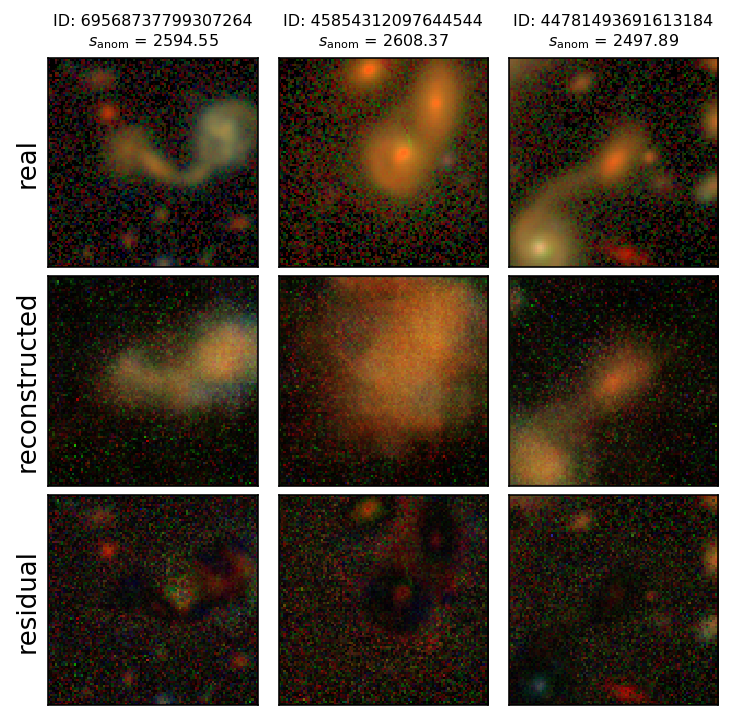

In [19]:
mergers_upper = [157767,147100,105162]
saveto = f'{plot_dir}/cluster_recon_mergers.png'
plot_recons(mergers_upper,saveto=saveto)

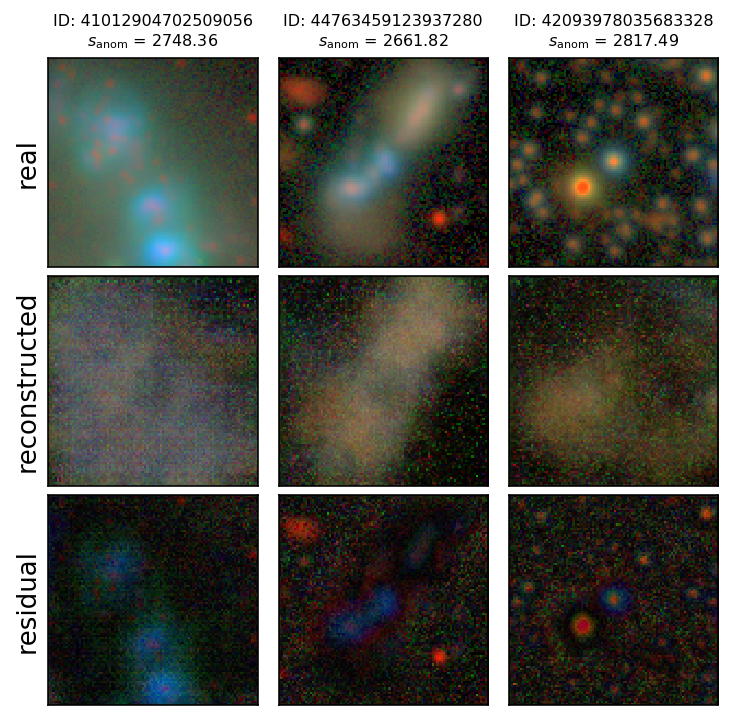

In [20]:
blue_sf = [461525, 86279,707620]#,782291]
saveto = f'{plot_dir}/cluster_recon_bluesf.png'
plot_recons(blue_sf,saveto=saveto)